## 1. Set up the Notebook and connect to the dataset

In [2]:
import pandas as pd
from pyecharts.charts import Map  
from pyecharts import options as opts
from IPython.display import HTML
import plotly.graph_objects as go

In [11]:
df = pd.read_excel('cleaned_artifacts.xlsx')

## 2. Preview the dataset

The database contains 9866 rows and 9 columns.
Columns are: 'Name', 'Provenance','Previous custodian or owner','Type', 'Period', 'Geography', 'Material','Dimension', 'EDAN ID'.

In [43]:
# 2.1 Get an overview of the numbers of both rows and columns
df.shape

(9866, 9)

In [44]:
# 2.2 Print the columns' name 
df.columns

Index(['Name', 'Provenance', 'Previous custodian or owner', 'Type', 'Period',
       'Geography', 'Material', 'Dimension', 'EDAN ID'],
      dtype='object')

## 3. Closer examination of the dataset

### 3.1 Column "Geography"

In [50]:
# Check how many objects don't have an origin, and who are they
missing_origin = df[df['Geography'].isnull()]

#print(missing_origin[['Name', 'Geography']])

print(len(missing_origin)) 

154


In [54]:
# filter rows with "or", which indicates uncertainties

geography_with_or = df[df['Geography'].str.contains(' or ', case=False, na=False)]

# print the results
print(len(geography_with_or['Geography']))

203


In [55]:
print(geography_with_or['Geography'])

413                                         Syria or Iran
497           Punjab, or Uttar Pradesh state, North India
550                             Bombay or Calcutta, India
755                                       Japan or Europe
1203                                       Egypt or Syria
                              ...                        
9683    Kimhae or Yangsan, Eastern Gyeongsangnam-do pr...
9696                       China or Ryukyu islands, Japan
9771                                       Korea or Japan
9783                                 Delhi or Agra, India
9862           Aichi prefecture or Gifu prefecture, Japan
Name: Geography, Length: 203, dtype: object


In [106]:
import pycountry
import pandas as pd

def get_country_name(location):
    if pd.isna(location):
        return None
    
    # 删除包含 "or" 的项
    if "or" in location.lower():
        return None
    
    # 使用逗号分割并识别国家
    parts = location.split(',')
    for part in reversed(parts):
        country_name = part.strip()
        
        # 排除以问号结尾的国家名称
        if country_name.endswith('?'):
            continue
        
        country = pycountry.countries.get(name=country_name)
        if country:
            return country.name
    
    return None

# 删除空值
cleaned_origins = df['Geography'].dropna()

# 使用上述函数获取国家名称
country_names = cleaned_origins.apply(get_country_name)

# 创建新的 Country 列
df['Country'] = country_names

# 打印处理后的 Country 列的值计数
print(df['Country'].value_counts())


Country
China             3230
Japan             1794
United States     1558
Egypt             1164
France             189
India              175
Italy              149
Iraq                13
Greece               7
Thailand             6
Indonesia            6
Sri Lanka            2
Uzbekistan           2
United Kingdom       1
Germany              1
Afghanistan          1
Sudan                1
Cyprus               1
Spain                1
Name: count, dtype: int64


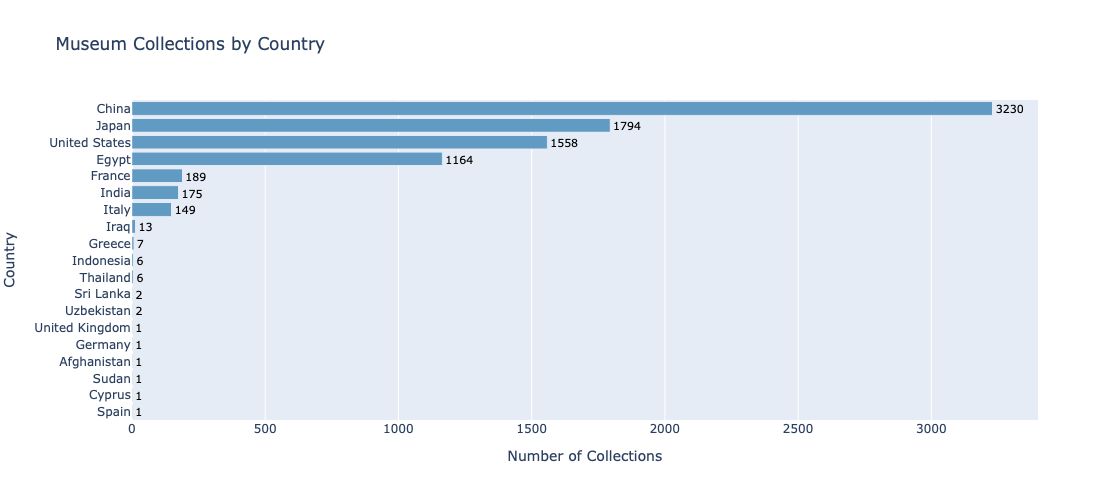

In [58]:
import plotly.graph_objects as go

# 获取国家计数数据并按数量降序排列
country_counts = df['Country'].value_counts().sort_values(ascending=False)

# 创建水平条形图
fig = go.Figure()

# 添加水平条形
fig.add_trace(go.Bar(
    y=country_counts.index[::-1],  # 反转 y 轴的数据顺序
    x=country_counts.values[::-1],  # 反转 x 轴的数据顺序
    orientation='h',
    marker=dict(color='#619AC3'),
    text=country_counts.values[::-1],  # 反转文本数据顺序
    textposition='outside',
    textfont=dict(color='black')
))

# 设置图表布局
fig.update_layout(
    title='Museum Collections by Country',
    xaxis_title='Number of Collections',
    yaxis_title='Country',
    height=500  # 设置图表高度为 500 像素
)

# 显示图表
fig.show()

In [60]:
from pyecharts.charts import Map
from pyecharts import options as opts
from pyecharts.render import make_snapshot
from snapshot_selenium import snapshot
from IPython.display import Image

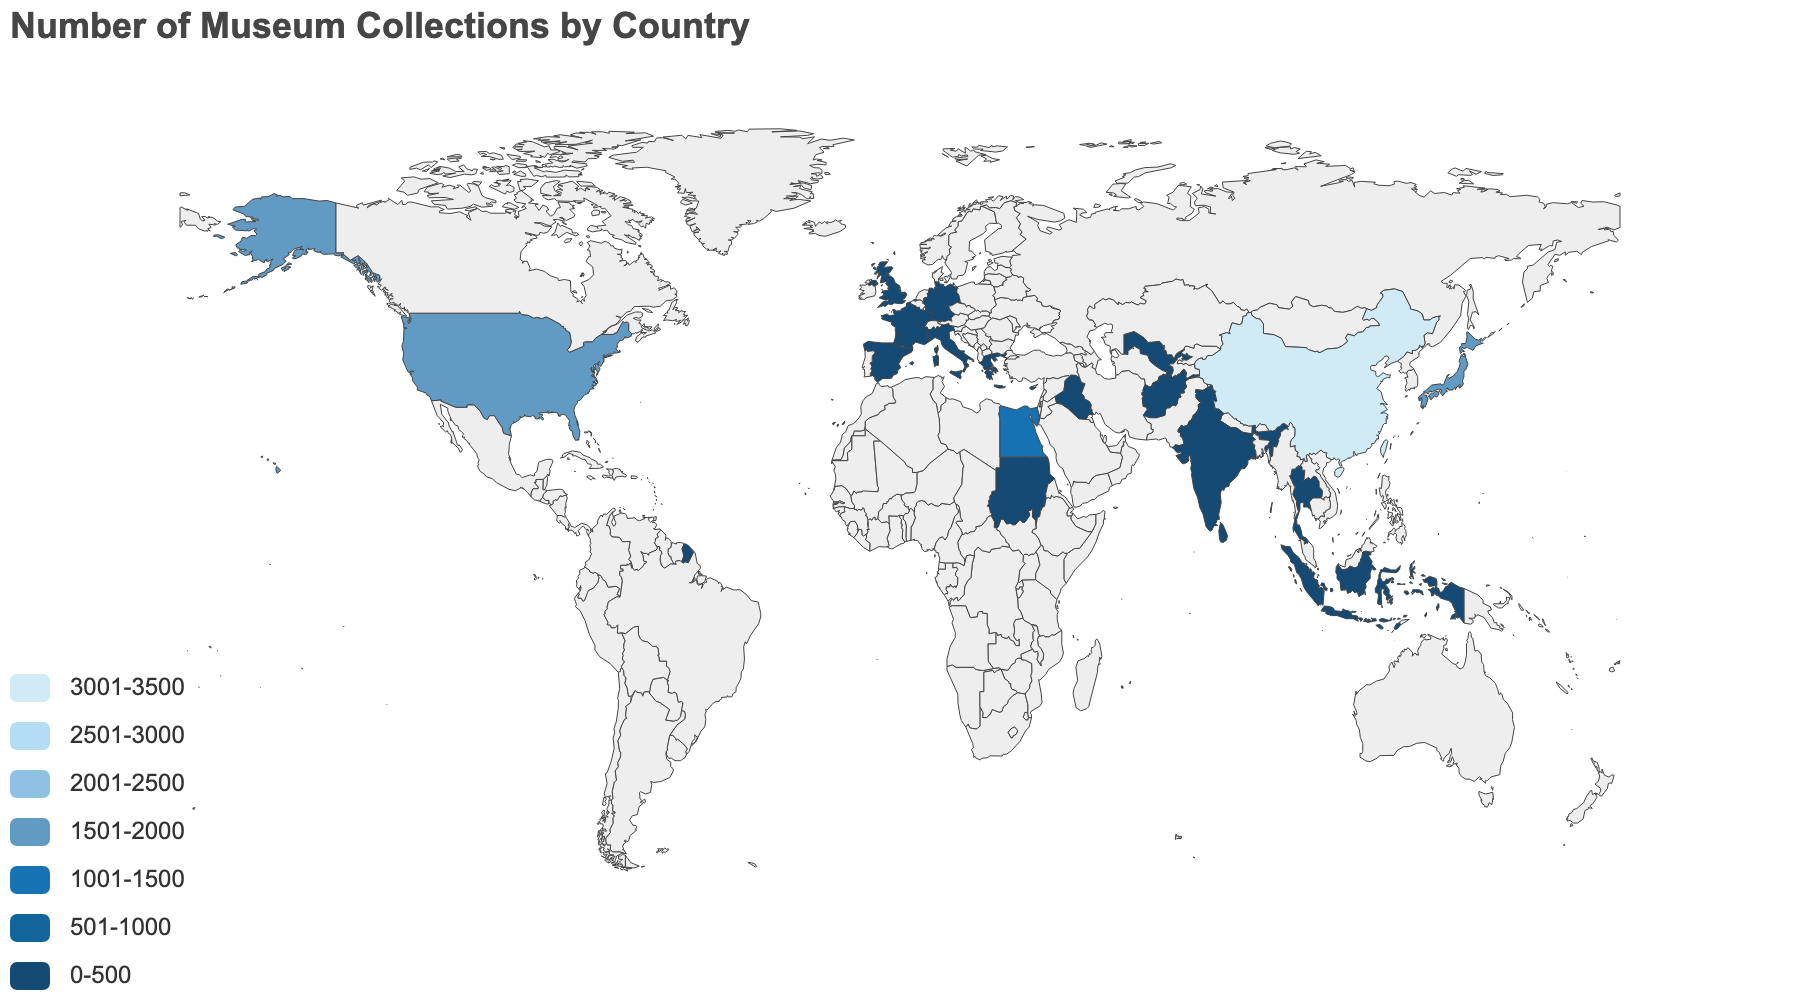

In [69]:
# Create a Map object
world_map = Map()

# Set global options for the map
world_map.set_global_opts(

    title_opts=opts.TitleOpts(title="Number of Museum Collections by Country"),
    visualmap_opts=opts.VisualMapOpts(
    
        max_=max(country_counts),
        is_piecewise=True,
        pieces=[
            {"min": 0, "max": 500, "label": "0-500", "color": "#144A74"},
            {"min": 501, "max": 1000, "label": "501-1000", "color": "#11659A"},
            {"min": 1001, "max": 1500, "label": "1001-1500", "color": "#1772b4"},
            {"min": 1501, "max": 2000, "label": "1501-2000", "color": "#619AC3"},
            {"min": 2001, "max": 2500, "label": "2001-2500", "color": "#8EC1E4"},
            {"min": 2501, "max": 3000, "label": "2501-3000", "color": "#B3DDF5"},
            {"min": 3001, "max": 3500, "label": "3001-3500", "color": "#D0EAF6"},
        ]
    )
)

# Add data to the map
world_map.add("", list(zip(country_counts.index, country_counts)), maptype="world")

# Set series options to customize the appearance of the plotted data points
world_map.set_series_opts(
    
    label_opts=opts.LabelOpts(is_show=False),  

    itemstyle_opts=opts.ItemStyleOpts(color="transparent")  
)

# Render the map and save it as an HTML file and a PNG image
make_snapshot(snapshot, world_map.render("world_map.html"), "world_map.png")

Image("world_map.png")


### 3.2 Column "Name"


In [91]:
name_counts = df['Name'].value_counts()
print(name_counts.head(15))

Name
Bead                                             552
Bowl                                             125
Jar                                              122
Garment hook (daigou)                             77
Disk (bi 璧)                                       61
Fragment                                          54
Ornament                                          51
Bottle                                            50
Vase                                              49
Mirror                                            45
Ball                                              43
Rose and Gold: The Little Lady Sophie of Soho     41
Dish                                              39
Stone gathered from the Yi River at Longmen       39
Tea bowl                                          36
Name: count, dtype: int64


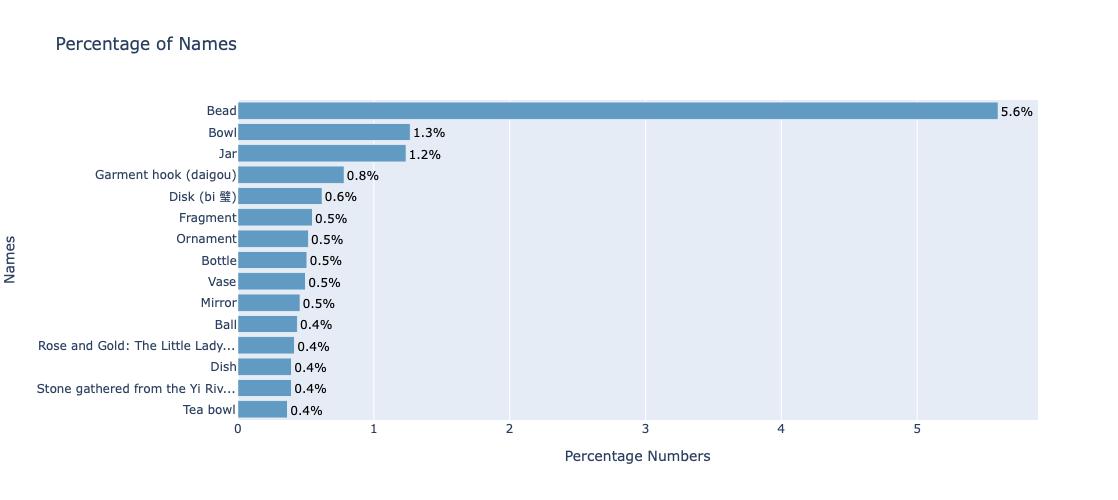

In [46]:

# 计算每个名字的百分比
name_percentages = name_counts / name_counts.sum() * 100

# 定义函数来选择前n个标签
def my_labels(labels, max_label_number=15):
    labels_len = len(labels)
    if labels_len <= max_label_number:
        return labels
    else:
        return labels[:max_label_number]

# 获取前15个标签（按百分比降序排列）
sorted_name_percentages = name_percentages.sort_values(ascending=False)
selected_name_labels = my_labels(sorted_name_percentages.index)
selected_name_percentages = sorted_name_percentages.loc[selected_name_labels]

# 反转顺序以确保绘图时从大到小排列
selected_name_labels = selected_name_labels[::-1]
selected_name_percentages = selected_name_percentages[::-1]

# 缩短标签，如果长度超过20个字符，加上省略号
shortened_labels = [label if len(label) <= 30 else label[:30] + '...' for label in selected_name_labels]

# 创建plotly图表
fig = go.Figure()

# 添加水平条形
fig.add_trace(go.Bar(
    y=shortened_labels,  # 使用缩短后的标签
    x=selected_name_percentages,  # 百分比按降序排列
    orientation='h',  # 水平条形图
    marker=dict(color='#619AC3'),
    text=[f'{pct:.1f}%' for pct in selected_name_percentages],  # 添加百分比标签
    textposition='outside',
    textfont=dict(color='black')  # 在条形外部显示文本
))

# 添加标题和轴标签
fig.update_layout(
    title="Percentage of Names",
    xaxis_title="Percentage Numbers",
    yaxis_title="Names",
    yaxis=dict(tickmode='linear'),  # 确保所有标签都显示
    height=500) 

# 显示图表
fig.show()


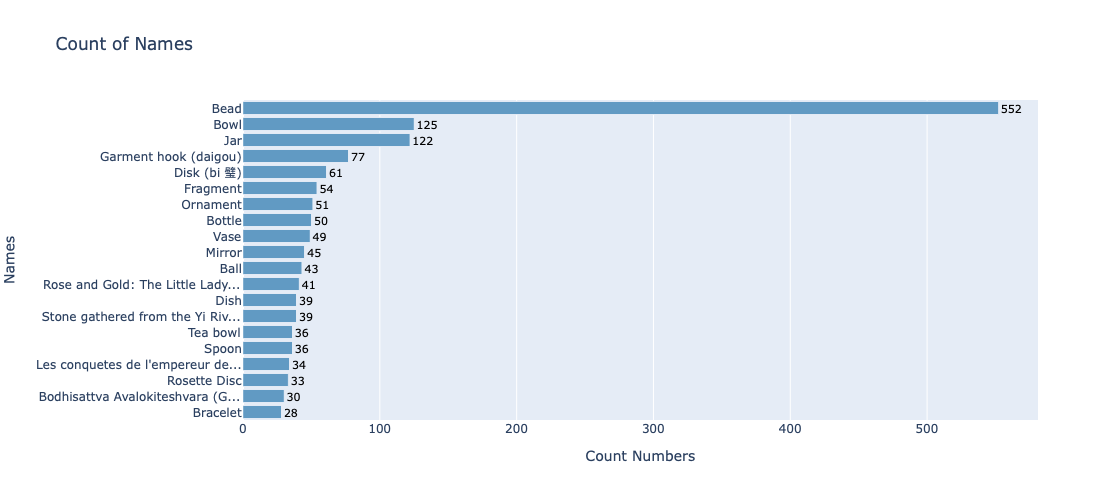

In [93]:
import pandas as pd
import plotly.graph_objects as go

# 假设这里有一个名为 name_counts 的 Series，包含每个名字的计数

# 定义函数来选择前n个标签
def my_labels(labels, max_label_number=20):
    labels_len = len(labels)
    if labels_len <= max_label_number:
        return labels
    else:
        return labels[:max_label_number]

# 获取前15个标签（按计数降序排列）
sorted_name_counts = name_counts.sort_values(ascending=False)
selected_name_labels = my_labels(sorted_name_counts.index)
selected_name_counts = sorted_name_counts.loc[selected_name_labels]

# 反转顺序以确保绘图时从大到小排列
selected_name_labels = selected_name_labels[::-1]
selected_name_counts = selected_name_counts[::-1]

# 缩短标签，如果长度超过20个字符，加上省略号
shortened_labels = [label if len(label) <= 30 else label[:30] + '...' for label in selected_name_labels]

# 创建plotly图表
fig = go.Figure()

# 添加水平条形
fig.add_trace(go.Bar(
    y=shortened_labels,  # 使用缩短后的标签
    x=selected_name_counts,  # 计数按降序排列
    orientation='h',  # 水平条形图
    marker=dict(color='#619AC3'),
    text=selected_name_counts,  # 直接显示计数值
    textposition='outside',
    textfont=dict(color='black')  # 在条形外部显示文本
))

# 添加标题和轴标签
fig.update_layout(
    title="Count of Names",  # 修改标题为 Count of Names
    xaxis_title="Count Numbers",  # 修改 x 轴标签为 Count Numbers
    yaxis_title="Names",
    yaxis=dict(tickmode='linear'),  # 确保所有标签都显示
    height=500) 

# 显示图表
fig.show()


In [48]:

# Filter columns named “Bead”
bead_items = df[df['Name'] == 'Bead']

# Check the Geography of these columns
geography_of_beads = bead_items['Geography'].value_counts()

print(geography_of_beads)


Geography
Egypt                     306
Syria                     106
Italy                      38
Venice, Italy              24
Korea                      11
China                       5
Central Asia                2
Lake Tai region, China      2
Name: count, dtype: int64


### 3.3 Material & Type

In [12]:
# Select the values of column "Material"
unique_materials = df['Material'].unique()

# Caculate the number
num_unique_materials = len(unique_materials)

print(f"The total number of materials：{num_unique_materials}")


The total number of materials：1474


In [13]:
material_counts = df['Material'].value_counts()
print(material_counts)

#print(unique_materials)

Material
glass                                                                                                                                                  1294
bronze                                                                                                                                                  645
ink and color on silk                                                                                                                                   607
ink on paper                                                                                                                                            590
etching; ink on paper                                                                                                                                   476
jade (nephrite)                                                                                                                                         249
jade                                                   

In [14]:
#Calculate the percentage of materials
material_counts = df['Material'].value_counts()
total_count = len(df)

material_percentages = material_counts / total_count * 100

# Display all rows
pd.set_option('display.max_rows', None)


print(material_percentages)

Material
glass                                                                                                                                                  13.115751
bronze                                                                                                                                                  6.537604
ink and color on silk                                                                                                                                   6.152443
ink on paper                                                                                                                                            5.980134
etching; ink on paper                                                                                                                                   4.824650
jade (nephrite)                                                                                                                                         2.523819
jade                     

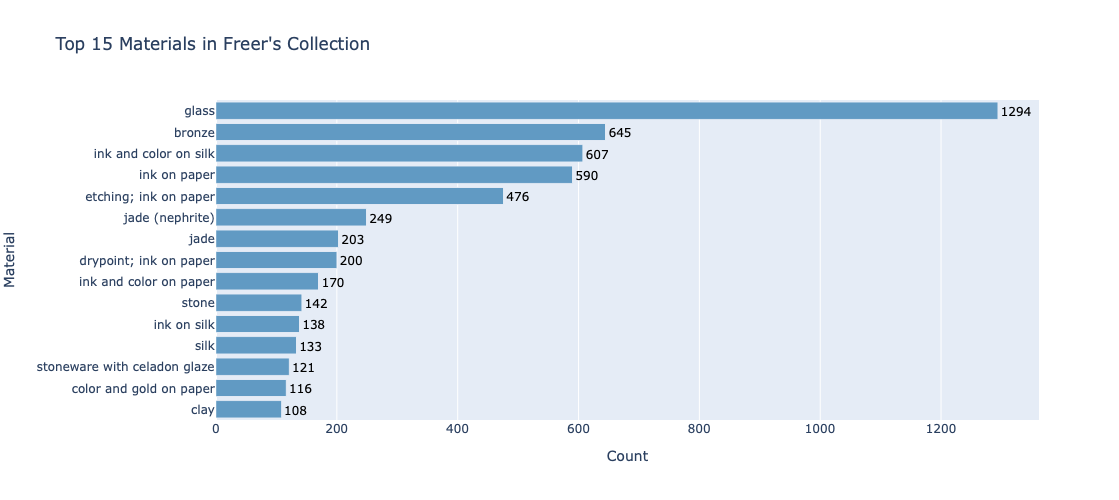

In [28]:
import plotly.graph_objects as go
import pandas as pd

# 假设您已经有了材质数据的计数
# material_counts = df['Material'].value_counts()

# 获取前15个材质的计数
top_materials = material_counts.head(15)

# 绘制条形图
fig = go.Figure()
fig.add_trace(go.Bar(
    y=top_materials.index[::-1],  # 水平条形图要反转顺序
    x=top_materials.values[::-1],  # 水平条形图要反转顺序
    orientation='h',  # 水平方向
    marker=dict(color='#619AC3'),
    text=top_materials.values[::-1],  # 显示数值
    textposition='outside',  # 数值显示在外部
    textfont=dict(color='black')  # 数值字体颜色
))

fig.update_layout(
    title='Top 15 Materials in Freer\'s Collection',
    xaxis_title='Count',
    yaxis_title='Material',
    height=500,
)

fig.show()


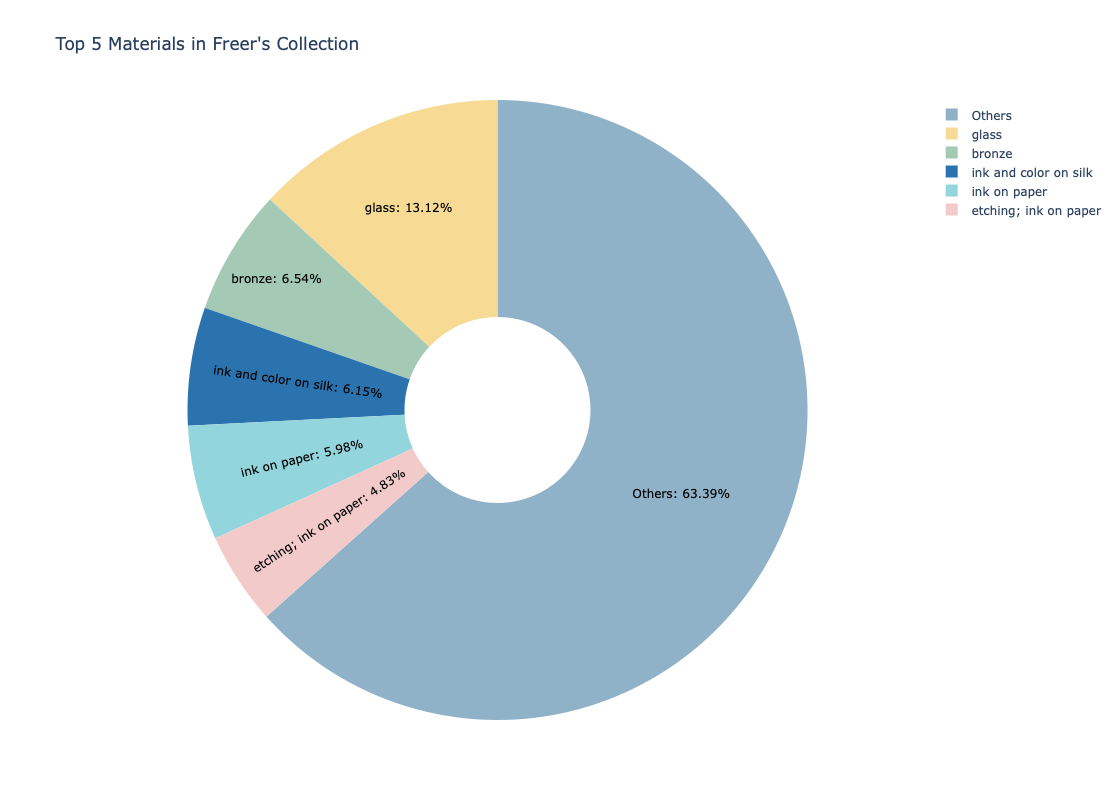

In [16]:
import plotly.graph_objects as go
import pandas as pd

# 假设您已经有了材质数据的计数
# material_counts = df['Material'].value_counts()

# 获取前5个材质的计数
top_materials = material_counts.head(5)

# 计算剩余材质的总数
other_count = material_counts[5:].sum()

# 创建饼图数据
labels = top_materials.index.tolist() + ['Others']
values = top_materials.tolist() + [other_count]

# 绘制饼图
fig = go.Figure(data=[go.Pie(labels=labels, values=values)])

# fig.update_traces(marker=dict(colors=['#144A74', '#11659A', '#1772b4', '#619AC3', '#8EC1E4', '#B3DDF5']),
fig.update_traces(marker=dict(colors=['#F7DA94', '#A4CAB6','#2B73AF', '#93D5DC', '#F2CAC9','#8FB2C9']),
                  textinfo='percent+label', 
                  textfont=dict(color='black'),
                  hole=0.3,
                  texttemplate='%{label}: %{percent:.2%}')  

fig.update_layout(
    title='Top 5 Materials in Freer\'s Collection',
    height=800, 
    width=800
)

fig.show()



In [108]:
glass_items = df[df['Material'] == 'Glass']

# 2. 统计每个国家的文物数量
glass_country_counts = glass_items['Geography'].value_counts()

# 打印结果
print(glass_country_counts)

Geography
Egypt                    772
Syria                    227
Venice, Italy             67
Italy                     55
Lombardy, Italy           17
Syria?                    11
Eastern Mediterranean     10
Arabian peninsula         10
China                      9
Italy?                     4
Korea                      3
Egypt or Syria             2
Germany?                   2
Iraq?                      1
Central Asia               1
Egypt?                     1
Name: count, dtype: int64


In [4]:
bronze_items = df[df['Material'] == 'Bronze']

# 2. 统计每个国家的文物数量
bronze_country_counts = bronze_items['Geography'].value_counts()

# 打印结果
print(bronze_country_counts)

Geography
China                                     445
Korea                                     127
Japan                                      24
Inner Mongolia/Ordos, China                21
Egypt                                       6
Anyang, probably Henan province, China      5
Iran                                        3
Thailand                                    2
China or Japan                              2
United States                               2
Yangzi River Valley, China                  1
Xingzheng, China                            1
Syria                                       1
India                                       1
China or Korea                              1
Near East                                   1
Afghanistan                                 1
middle Yangzi River region, China           1
Name: count, dtype: int64


In [6]:
silk_items = df[df['Material'] == 'Ink and color on silk']

# 2. 统计每个国家的文物数量
silk_country_counts = silk_items['Geography'].value_counts()

# 打印结果
print(silk_country_counts)

Geography
China                                515
Japan                                 87
Possibly Zhejiang province, China      1
Name: count, dtype: int64


In [18]:
# Select the values of column "Material"
unique_types = df['Type'].unique()

# Caculate the number
num_unique_types = len(unique_types)

print(f"The total number of types：{num_unique_types}")

The total number of types：31


In [21]:
type_counts = df['Type'].value_counts()

# 显示所有结果
pd.set_option('display.max_rows', None)
print(type_counts)

Type
painting                    2163
jewelry and ornament        1888
vessel                      1859
print                       1143
sculpture                    586
tool and equipment           354
costume and textile          295
ceremonial object            291
drawing                      277
unclassified                 181
manuscript                   145
container                    135
furniture and furnishing     114
architectural element         80
mirror                        73
frame                         57
weapon and armament           48
exchange media                44
natural material              42
musical instrument            33
model                         17
costume accessory             12
mask                           8
toy and entertainment          7
calligraphy                    6
book                           2
album                          2
\ntool and equipment           1
rubbing                        1
photograph                     1
docum

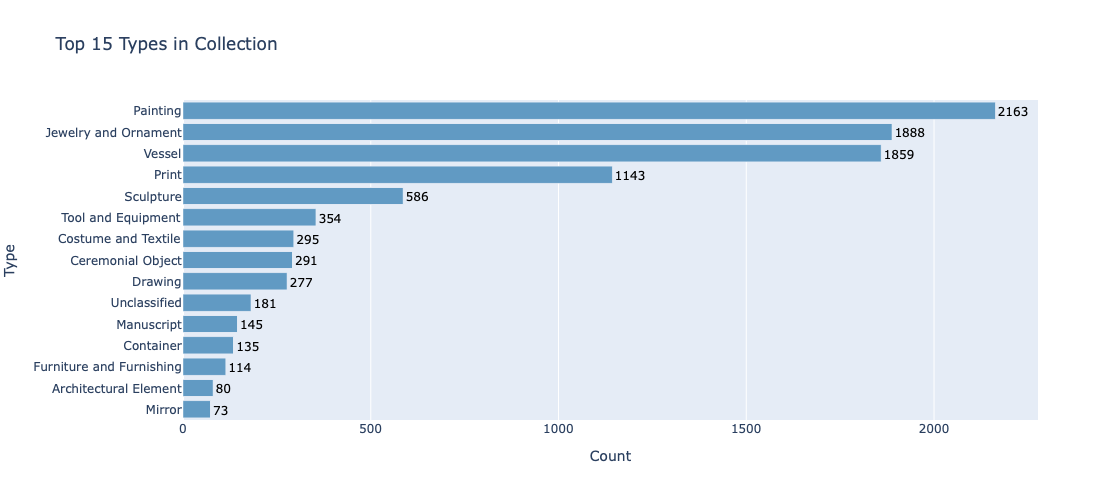

In [116]:
# 只选择前15个类型
top_types = type_counts.head(15)

# 绘制水平条形图
fig = go.Figure()
fig.add_trace(go.Bar(
    y=top_types.index[::-1],  # 水平条形图要反转顺序
    x=top_types.values[::-1],  # 水平条形图要反转顺序
    orientation='h',  # 水平方向
    marker=dict(color='#619AC3'),
    text=top_types.values[::-1],  # 显示计数值
    textposition='outside',  # 数值显示在外部
    textfont=dict(color='black')  # 数值字体颜色
))

fig.update_layout(
    title='Top 15 Types in Collection',
    xaxis_title='Count',
    yaxis_title='Type',
    height=500,
)

fig.show()

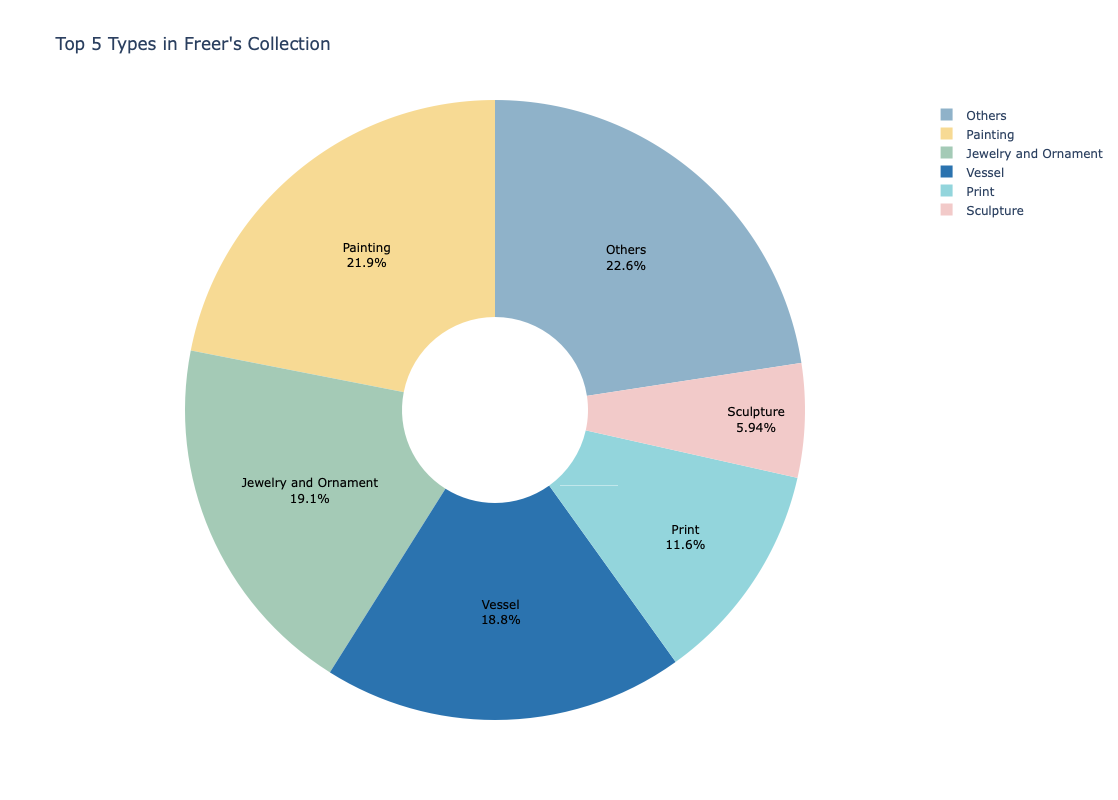

In [113]:


# 获取前5个材质的计数
top_types = type_counts.head(5)

# 计算剩余材质的总数
other_count = type_counts[5:].sum()

# 创建饼图数据
labels = top_types.index.tolist() + ['Others']
values = top_types.tolist() + [other_count]

# 绘制饼图
fig = go.Figure(data=[go.Pie(labels=labels, values=values)])

# fig.update_traces(marker=dict(colors=['#144A74', '#11659A', '#1772b4', '#619AC3', '#8EC1E4', '#B3DDF5']),
fig.update_traces(marker=dict(colors=['#F7DA94', '#A4CAB6','#2B73AF', '#93D5DC', '#F2CAC9','#8FB2C9']),
                  textinfo='percent+label', 
                  textfont=dict(color='black'),
                  hole=0.3)  # 设置中间的空白大小

fig.update_layout(
    title='Top 5 Types in Freer\'s Collection',
    height=800, 
    width=800
)

fig.show()


In [24]:
painting_items = df[df['Type'] == 'painting']

# 2. 统计每个国家的文物数量
painting_country_counts = painting_items['Geography'].value_counts()

# 打印结果
print(painting_country_counts)

Geography
China                                                 1001
Japan                                                  739
United States                                          239
India                                                  115
Tibet                                                   17
Kyoto, Japan                                            10
Delhi or Agra, India                                     3
Bijapur, Karnataka state, Deccan plateau, India          3
Golconda, Telangana state, Deccan plateau, India         3
Isfahan, Iran                                            2
Korea or China                                           2
Korea                                                    2
China or Korea                                           2
Egypt                                                    2
Jaipur, Rajasthan state, India                           2
Lucknow, Uttar Pradesh state, Avadh (Oudh), India        2
Bikaner, Rajasthan state, India               

In [25]:
jewelry_items = df[df['Type'] == 'jewelry and ornament']

jewelry_country_counts = jewelry_items['Geography'].value_counts()

print(jewelry_country_counts)

Geography
Egypt                                                       813
China                                                       419
Syria                                                       186
Korea                                                       131
Italy                                                        53
Venice, Italy                                                45
Lake Tai region, China                                       29
Central Asia                                                 21
Lombardy, Italy                                              17
Iran                                                         14
Arabian peninsula                                            10
India                                                         9
Inner Mongolia/Ordos, China                                   7
Syria?                                                        6
Istanbul, Turkey                                              5
Eastern Mediterranean         

In [26]:
vessel_items = df[df['Type'] == 'vessel']

# Caculate the number of each country
vessel_country_counts = vessel_items['Geography'].value_counts()


print(vessel_country_counts)

Geography
China                                                                                                               229
Raqqa, Syria                                                                                                        134
Kyoto, Kyoto prefecture, Japan                                                                                      131
Japan                                                                                                                78
Iran                                                                                                                 71
Gangjin or Buan kilns, Jeolla-do province, Korea                                                                     69
Egypt                                                                                                                57
Henan province, China                                                                                                44
Detroit, Michigan, United Stat

### 3.4 Timeline

In [30]:
# 清洗Provenance一列
#修改原来的格式

class Provenance:
    def __init__(self, from_year, to_year, buyer):
        self.from_year = from_year
        self.to_year = to_year
        self.buyer = buyer

    def __str__(self):
        return f'{self.buyer}: {self.from_year} - {self.to_year}'



for index, collection in df.iterrows():
    provenance = collection['Provenance']
    # print(f'Name: {collection["Name"]}')
    # print(f'Provenance:\n{provenance}')
    if isinstance(provenance, str):
        rows = provenance.split('\n')
        provenances = []
        for i in range(0, len(rows), 2):
            if rows[i].startswith('To'):
                from_yr = '0'
                to_yr = rows[i].split(' ')[1]
                buyer = rows[i+1].split(',')[0]
                provenances.append(Provenance(from_yr, to_yr, buyer))
            elif rows[i].startswith('From'):
                items = rows[i].split(' ')
                from_yr = items[1]
                to_yr = items[3] if len(items) == 4 else 'now'
                buyer = rows[i + 1].split(',')[0]
                provenances.append(Provenance(from_yr, to_yr, buyer))
            elif rows[i].startswith('Notes'):
                break

        df.at[index, 'Provenance'] = '\n'.join(map(str, provenances))

# China_collections_df = China_collections_df.drop(columns=['Credit Line'])
df.to_excel('Collections_Provenance.xlsx', index=False)


In [31]:
# 提取购买时间
provenance_df = pd.read_excel('Collections_Provenance.xlsx')

# 填充空值
import re

# 在'Provenance'列中填充空值
provenance_df['Provenance'].fillna('', inplace=True)

# 定义一个函数来提取购入年份
def extract_purchase_year(provenance):
    # 在正则表达式中使用更具体的模式匹配购入年份信息
    match = re.search(r'Charles Lang Freer \(1854.*1919\):.*?(\d{4})', provenance)
    
    if match:
        return match.group(1)
    else:
        return None



# 应用提取函数到'Provenance'列，并创建一个新列存储提取的年份信息
provenance_df['Purchase_Year'] = provenance_df['Provenance'].apply(extract_purchase_year)


provenance_df.to_excel('Collections_Provenance.xlsx', index=False)


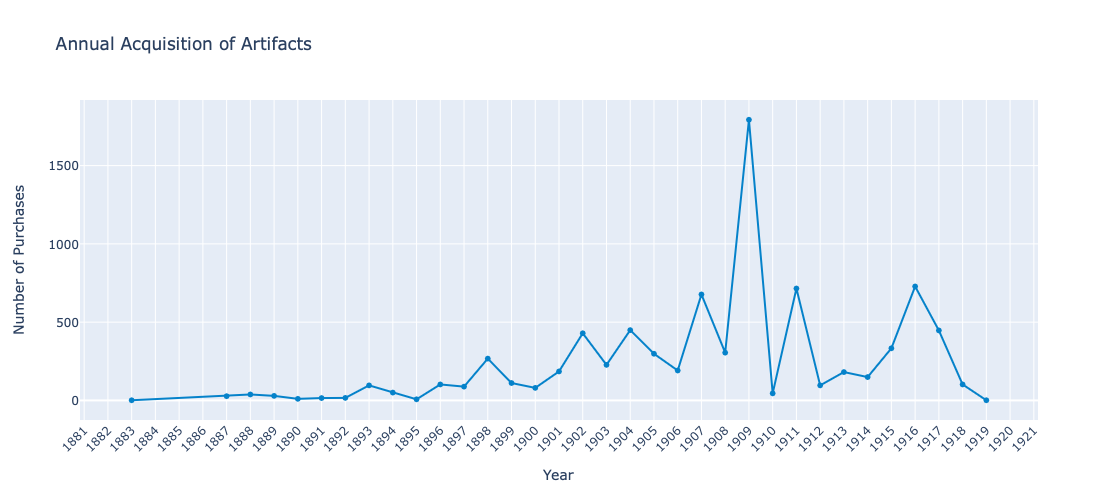

In [33]:
# import pandas as pd# import plotly.graph_objects as go

# Read the file
df = pd.read_excel('Collections_Provenance.xlsx')

# Calculate the number for each year
purchase_year_counts = df['Purchase_Year'].value_counts().sort_index()

# Create the graph
fig = go.Figure()

# Add the line
fig.add_trace(go.Scatter(x=purchase_year_counts.index, y=purchase_year_counts.values,
                    mode='lines+markers',
                    name='Number of Purchases',
                    line=dict(color='#0582ca')))  

# Set the layout
fig.update_layout(title='Annual Acquisition of Artifacts',
                   xaxis_title='Year',
                   yaxis_title='Number of Purchases',
                   xaxis=dict(tickmode='linear', tickangle=-45),  
                   yaxis=dict(type='linear'),
                   height=500)  

# Show the table
fig.show()

In [35]:

# Calculate the number of purchases for each year
purchase_year_counts = df['Purchase_Year'].value_counts().sort_index()

# Print the number of purchases for each year
print(purchase_year_counts)


Purchase_Year
1883.0       1
1887.0      27
1888.0      38
1889.0      29
1890.0      10
1891.0      15
1892.0      16
1893.0      96
1894.0      50
1895.0       7
1896.0     102
1897.0      88
1898.0     267
1899.0     111
1900.0      80
1901.0     185
1902.0     429
1903.0     227
1904.0     449
1905.0     298
1906.0     191
1907.0     677
1908.0     305
1909.0    1793
1910.0      45
1911.0     715
1912.0      96
1913.0     181
1914.0     149
1915.0     333
1916.0     728
1917.0     447
1918.0     102
1919.0       1
Name: count, dtype: int64
